In [2]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import PIL.ImageDraw
import PIL.ImageColor
from boto3 import Session
import boto3
from boto3.dynamodb.conditions import Key
from boto3 import resource
import os.path

In [268]:
def get_drawing(img_path):
    pil_im = Image.open(img_path)
    (r,g,b,a) = pil_im.split()
    d = a.point(lambda x: 100 if x < 255 else 0)
    #drawing_img = Image.merge('RGBA', (d,d,d,Image.new('L', d.size, color=255)))
    drawing_img = Image.merge('RGB', (d,d,d))
    
    regions = []

    # THis is quite side-effecty. Fill in drawing_img as we go, adding regions.
    for x in range(drawing_img.width):
        for y in range(drawing_img.height):
            c = drawing_img.getpixel((x,y))
            if c == (100,100,100):
                PIL.ImageDraw.floodfill(drawing_img, (x,y), (255,255,255))
                regions.append((x,y))
                
    return (drawing_img, regions)

In [263]:
def fetch_regions(image_name):
    dynamodb_resource = resource('dynamodb', 'us-west-2')
    table = dynamodb_resource.Table('ColorBot')
    response = table.query(
        TableName='ColorBot',
        KeyConditionExpression=Key('ImageName').eq(image_name))
    
    if response['ResponseMetadata']['HTTPStatusCode'] != 200:
        raise Exception("Expected region")
        # TODO: Logging
        
    return response
    

In [264]:
def fill_regions(drawing, regions, items):
    for item in items:
        try:
            region = int(item['Region'])
            if region < len(regions) and region >= 0:
                (rs, gs, bs) = item['Color'].split(',')
                color = (int(rs), int(gs), int(bs))
                PIL.ImageDraw.floodfill(drawing, regions[region], color)
        except Exception as e: pass

In [265]:
def build_colored_drawing(image_folder, image_name):
    image_path = os.path.join(image_folder, image_name)
    
    (drawing, regions) = get_drawing(image_path)
    
    coloring = fetch_regions(image_name)
    
    fill_regions(drawing, regions, coloring['Items'])
    
    fg = Image.open(image_path)
    
    (bg_r, bg_g, bg_b) = drawing.split()
    # Should just start with alpha layer... too lazy.
    bg = Image.merge('RGBA', (r,g,b,Image.new('L', d.size, color=255)))
    
    bg.paste(fg, (0,0), fg)
    
    return bg

In [3]:
pil_im = Image.open('test-images/test1.png')

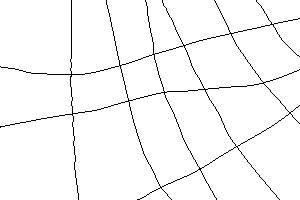

In [140]:
pil_im

In [4]:
pil_im.width

300

In [5]:
(r,g,b,a) = pil_im.split(); (r,g,b,a)

(<PIL.Image.Image image mode=L size=300x200 at 0x7F2F83565A90>,
 <PIL.Image.Image image mode=L size=300x200 at 0x7F2F83565AC8>,
 <PIL.Image.Image image mode=L size=300x200 at 0x7F2F83565A20>,
 <PIL.Image.Image image mode=L size=300x200 at 0x7F2F83565A58>)

In [6]:
d = a.point(lambda x: 100 if x < 255 else 0)

In [7]:
d.width

300

In [143]:
# [drawing_bounds.getpixel((x,0)) for x in range(100)]

In [144]:
d.mode

'L'

In [145]:
# Floodfill in PIL only works with RGB...

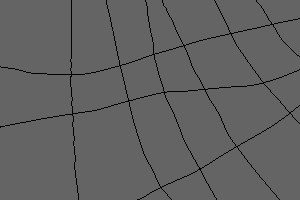

In [150]:
drawing_img = Image.merge('RGB', (d,d,d)); drawing_img

Now the floodable background is grey 100,100,100 and the lines are black 0,0,0

In [152]:
#PIL.ImageDraw.floodfill(drawing_img, (0,0), (255,255,255))

In [153]:
regions = []

for x in range(drawing_img.width):
    for y in range(drawing_img.height):
        c = drawing_img.getpixel((x,y))
        if c == (100,100,100):
            PIL.ImageDraw.floodfill(drawing_img, (x,y), (255,255,255))
            regions.append((x,y))
            
regions

[(0, 0),
 (0, 67),
 (0, 128),
 (71, 59),
 (71, 77),
 (73, 114),
 (107, 0),
 (121, 66),
 (129, 101),
 (140, 199),
 (146, 0),
 (155, 54),
 (162, 187),
 (163, 0),
 (165, 93),
 (185, 46),
 (201, 169),
 (206, 90),
 (215, 0),
 (232, 34),
 (238, 146),
 (257, 0),
 (264, 83),
 (274, 24),
 (291, 112)]

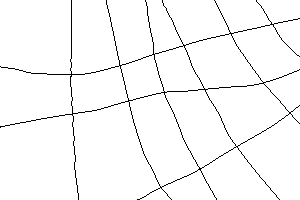

In [154]:
drawing_img

Now in theory, drawing_img is our drawable image and we can still overlay our original image

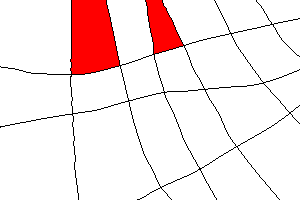

In [291]:
PIL.ImageDraw.floodfill(drawing_img, regions[3], PIL.ImageColor.getcolor('red', 'RGB')); drawing_img

In [157]:
aws = Session()

In [173]:
client = boto3.client('dynamodb', 'us-west-2')
dynamodb_resource = resource('dynamodb', 'us-west-2')

In [174]:
table = dynamodb_resource.Table('ColorBot')

In [289]:
response = table.query(
    TableName='ColorBot',
    KeyConditionExpression=Key('ImageName').eq('test1.png'))
response
    

{'Count': 1,
 'Items': [{'Color': '100,220,100',
   'ImageName': 'test1.png',
   'Region': Decimal('3')}],
 'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '117',
   'content-type': 'application/x-amz-json-1.0',
   'date': 'Mon, 05 Feb 2018 06:49:33 GMT',
   'server': 'Server',
   'x-amz-crc32': '560217295',
   'x-amzn-requestid': 'AM2V5H5BGJHQLB7T5SEGVH8GPRVV4KQNSO5AEMVJF66Q9ASUAAJG'},
  'HTTPStatusCode': 200,
  'RequestId': 'AM2V5H5BGJHQLB7T5SEGVH8GPRVV4KQNSO5AEMVJF66Q9ASUAAJG',
  'RetryAttempts': 0},
 'ScannedCount': 1}

In [295]:
response = table.put_item(Item={'ImageName': 'test1.png', 'Region': 7, 'Color': '220,100,100'})

In [301]:
response = table.put_item(Item={'ImageName': '__CONTROL', 'Region': -1, 'CurrentImageName': 'test1.png'})

In [302]:
table.get_item(Key={'ImageName': '__CONTROL', 'Region': -1})

{'Item': {'CurrentImageName': 'test1.png',
  'ImageName': '__CONTROL',
  'Region': Decimal('-1')},
 'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '97',
   'content-type': 'application/x-amz-json-1.0',
   'date': 'Mon, 05 Feb 2018 07:14:23 GMT',
   'server': 'Server',
   'x-amz-crc32': '692899097',
   'x-amzn-requestid': 'STOUOIH5C3MO1O5M1Q8V9TAVM7VV4KQNSO5AEMVJF66Q9ASUAAJG'},
  'HTTPStatusCode': 200,
  'RequestId': 'STOUOIH5C3MO1O5M1Q8V9TAVM7VV4KQNSO5AEMVJF66Q9ASUAAJG',
  'RetryAttempts': 0}}

In [182]:
dir(response)

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [189]:
response['ResponseMetadata']['HTTPStatusCode']

200

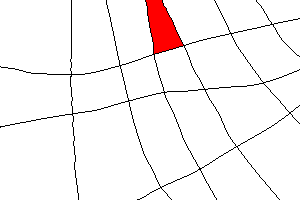

In [190]:
drawing_img

In [231]:
(d, rs) = get_drawing('test-images/test1.png')

In [232]:
c_rs = fetch_regions('test1.png')

In [233]:
c_rs['Items']

[{'Color': '100,220,100', 'ImageName': 'test1.png', 'Region': Decimal('0')}]

In [237]:
fill_regions(d, rs, c_rs['Items'])

In [285]:
def build_colored_drawing(image_folder, image_name):
    image_path = os.path.join(image_folder, image_name)
    
    (drawing, regions) = get_drawing(image_path)
    
    coloring = fetch_regions(image_name)
    
    fill_regions(drawing, regions, coloring['Items'])
    
    fg = Image.open(image_path)
    
    (bg_r, bg_g, bg_b) = drawing.split()
    # Should just start with alpha layer... too lazy.
    bg = Image.merge('RGBA', (r,g,b,Image.new('L', d.size, color=255)))
    
    bg.paste(fg, (0,0), fg)
    
    return bg

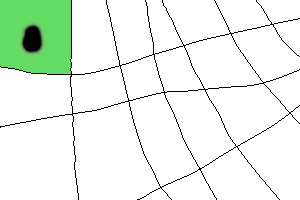

In [290]:
d = build_colored_drawing('test-images', 'test1.png'); d

In [271]:
(r,g,b) = d.split()

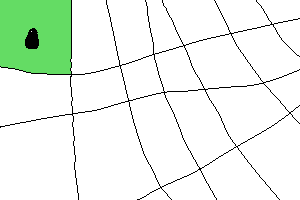

In [282]:
bg = Image.merge('RGBA', (r,g,b,Image.new('L', d.size, color=255)));bg

In [283]:
fg = Image.open('test-images/test1.png')

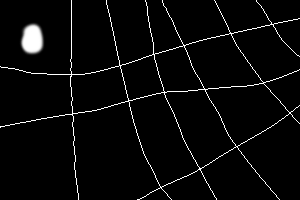

In [280]:
(_,_,_,fg_alpha) = fg.split(); fg_alpha

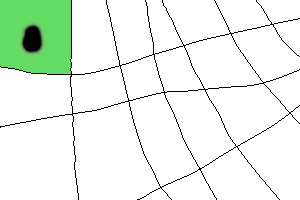

In [284]:
bg.paste(fg, (0,0), fg); bg